In [1]:
import numpy as np
import copy
from scipy import stats
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
import matplotlib as mpl
import matplotlib.colors as mcolors
import cmocean

In [2]:
def calc_stats(nep_val_stats, comp_val_stats, area_val):
    # CALCULATE STATISTICS
    nan_idx = ~np.isnan(nep_val_stats)*~np.isnan(comp_val_stats)
    
    # Mean Bias
    mean_bias = np.nanmean((nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    mean_bias = np.nansum(((nep_val_stats*area_val)[nan_idx]-(comp_val_stats*area_val)[nan_idx])/np.nansum(area_val[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', mean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((nep_val_stats-comp_val_stats)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    rmse = np.sqrt(np.sum((((nep_val_stats-comp_val_stats)**2)*area_val)[nan_idx]/np.sum(area_val[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', rmse)
        
    # Median absolute error
    medae = np.nanmedian(np.abs(nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    corr = stats.pearsonr(nep_val_stats[nan_idx].ravel(), comp_val_stats[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)
    
    return mean_bias, rmse, medae, corr

In [3]:
def plot_map(clon,clat,lon,lat,var_val,vmin,vmax,cmap,norm,c_inc):

    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))

    C = ax.pcolormesh(clon,clat,var_val, transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm)
    
    levels = np.arange(vmin,vmax+c_inc/2,c_inc)

    CS = ax.contour(lon,lat,var_val,levels, colors='k', transform=ccrs.PlateCarree())
                            
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = False
    gl.top_labels = False

        
    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
    
    if nrow == 6:
        gl.bottom_labels = True
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    
    pos = ax.get_position()
    cbar_x = pos.x0
    pos_ref = plt.gcf().axes[0].get_position()
    cbar_h = .1*pos_ref.height
    cbar_y = pos_ref.y0 -.25*pos_ref.height
    
    if ncol == 1:
        cax = fig.add_axes([pos_ref.x0, cbar_y, 2*pos.width, cbar_h])
        cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
        cbar.ax.set_xticks(levels[::2])
        cax.plot([levels]*2, [0, 1], 'k')
        cbar.ax.tick_params(labelsize=16)
        cax.set_xlabel(('Depth of Hypoxic Boundary (m)'),fontsize=20)
            
    elif ncol == 3:
        cax = fig.add_axes([pos.x0, cbar_y, pos.width, cbar_h])
        cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
        cbar.ax.locator_params(nbins=5)
        cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
        cax.plot([levels[levels<0]]*2, [0, 1], '--k')
        cbar.ax.tick_params(labelsize=16)
        cax.set_xlabel((r'$\Delta$ Depth (m)'),fontsize=20)
    # Labels
    #if ncol == 0:
    #    plt_lab = depths_dict[dep]['plt_lab']   
    #    ax.text(243.0, 56, plt_lab, transform=ccrs.PlateCarree(), fontsize=25, ha='center', zorder=53)
    if ncol == 3:
        #stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
        #ax.text(231.5, 60, stats_text, 
        #        fontsize=16, ha='left', va='center',transform=ccrs.PlateCarree(), zorder=53)
        stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
        ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)
    # Titles
    if (nrow == 0) or (nrow == 4):
        if ncol == 0:
            title_text = 'NEP10k'
        elif ncol == 1:
            title_text = 'WOA23'
        else:
            title_text = 'NEP10k - WOA23'
        
        ax.set_title(title_text, fontsize=28)
        
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)  
    
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())    
  

In [4]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] + mod_dict[src_model]['fil_pre'] 
             + '_' + ox_dict[nutrient][src_model]['fil_str'] 
             + season_dict[season][src_model] + mod_dict[src_model]['fil_suf']  + '.nc')
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
            
    if src_model == 'NEP':
        ds = ds.rename({'z_l':'depth'})
        
    return ds

In [5]:
def get_coords(src_model,ds):
 
    if src_model == 'WOA':
        lat = ds.lat.values
        lon = ds.lon.values
        clat = np.append(ds.lat_bnds.values[:,0],ds.lat_bnds.values[-1,-1])
        clon = np.append(ds.lon_bnds.values[:,0],ds.lon_bnds.values[-1,-1])

    elif src_model == 'NEP':
 
        lon = nep_lon
        lat = nep_lat
        clon = nep_clon 
        clat = nep_clat
        
    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    return lat,lon,clat,clon,chuk_mask

In [6]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [7]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)


In [8]:
def calc_hypox_bound(ds,o2_data):
    
    depth = ds.depth.values
    nlats = o2_data.shape[-2]
    nlons = o2_data.shape[-1]
    
    if np.ndim(o2_data)>3:
        hypox_bot_idx = np.argmax(o2_data<do_conc_hypox,axis=1) # first occurance in depth where below hypoxic limit
        hypox_top_idx = hypox_bot_idx -1                        # one depth level shallower
        
        nts = o2_data.shape[0]
        
        sub_o2 = np.take_along_axis(o2_data, hypox_bot_idx[:, np.newaxis, :], 1).reshape(nts, nlats,nlons)
        sup_o2 = np.take_along_axis(o2_data, hypox_top_idx[:, np.newaxis, :], 1).reshape(nts, nlats,nlons)
        
        depth_array = np.tile(depth[np.newaxis,:,np.newaxis,np.newaxis],(nts,nlats,nlons))
        
        sub_depth = np.take_along_axis(depth_array,hypox_bot_idx[:, np.newaxis, :], 1).reshape(nts,nlats,nlons)
        sup_depth = np.take_along_axis(depth_array,hypox_top_idx[:, np.newaxis, :], 1).reshape(nts,nlats,nlons)
        
    else: 
       
        hypox_bot_idx = np.argmax(o2_data<do_conc_hypox,axis=0)
        hypox_top_idx = hypox_bot_idx -1
        
        sub_o2 = np.take_along_axis(o2_data, hypox_bot_idx[np.newaxis, :], 0).reshape(nlats,nlons)
        sup_o2 = np.take_along_axis(o2_data, hypox_top_idx[np.newaxis, :], 0).reshape(nlats,nlons)
        
        depth_array = np.tile(depth[:,np.newaxis,np.newaxis],(nlats,nlons))
        
        sub_depth = np.take_along_axis(depth_array,hypox_bot_idx[np.newaxis, :], 0).reshape(nlats,nlons)
        sup_depth = np.take_along_axis(depth_array,hypox_top_idx[np.newaxis, :], 0).reshape(nlats,nlons)
    
    do2 = sup_o2 - sub_o2
    dz = -(sup_depth - sub_depth)
    
    delta_z = (sup_o2 - do_conc_hypox) / (do2/dz)
    
    hypox_depth_interp = sup_depth + delta_z
    
    return hypox_depth_interp.squeeze()
    

In [9]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

In [10]:
mod_dict = {'NEP':{'dir':'/work/role.medgrp/NEP/plotting/Figure_13/',
                   'fil_pre':'nep',
                   'fil_suf':'_ts',},
            'WOA':{'dir':'/work/role.medgrp/NEP/plotting/Figure_13/',
                   'fil_pre':'woa23_all',
                   'fil_suf':'_01',
                   'plt_title':'Regional Dataset'},}

ox_dict = {'Oxygen':{'NEP':{'fil_str':'o2_','var_nm':'o2','k':1000000},
                              'WOA':{'fil_str':'o', 'var_nm':'o_an','k':1},
                              'units':r'$\mu$mol kg$^{-1}$',
                              'vmin':0,'vmax':400,'cbar_n':11, 'inc':25, 
                              'dif_range':50, 'dif_cbar_n':25, 'dif_inc':25},}

season_dict = {'mean':   {'NEP':'1993-2019_mean', 'WOA': '00'},}

abs_min = 100
abs_max = 700
dif_range = 100

cmap1 = mpl.cm.gnuplot_r
bounds = np.linspace(abs_min,abs_max,25)
norm1 = mcolors.BoundaryNorm(bounds, cmap1.N, extend='both')

cmap2 = cmocean.cm.balance
bounds = np.linspace(-dif_range,dif_range,17)
norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')

plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']

/work/role.medgrp/NEP/plotting/Figure_13/nep_o2_1993-2019_mean_ts.nc
/work/role.medgrp/NEP/plotting/Figure_13/woa23_all_o00_01.nc
MEAN BIAS: 45.298286784348285
AREA-WEIGHTED MEAN BIAS: 46.09687250444639
RMSE: 64.80590181250389
AREA-WEIGHTED RMSE: 66.10160860328166
MEDIAN ABSOLUTE ERROR: 36.220740261752496
CORRELATION: PearsonRResult(statistic=0.9508721990764596, pvalue=0.0)


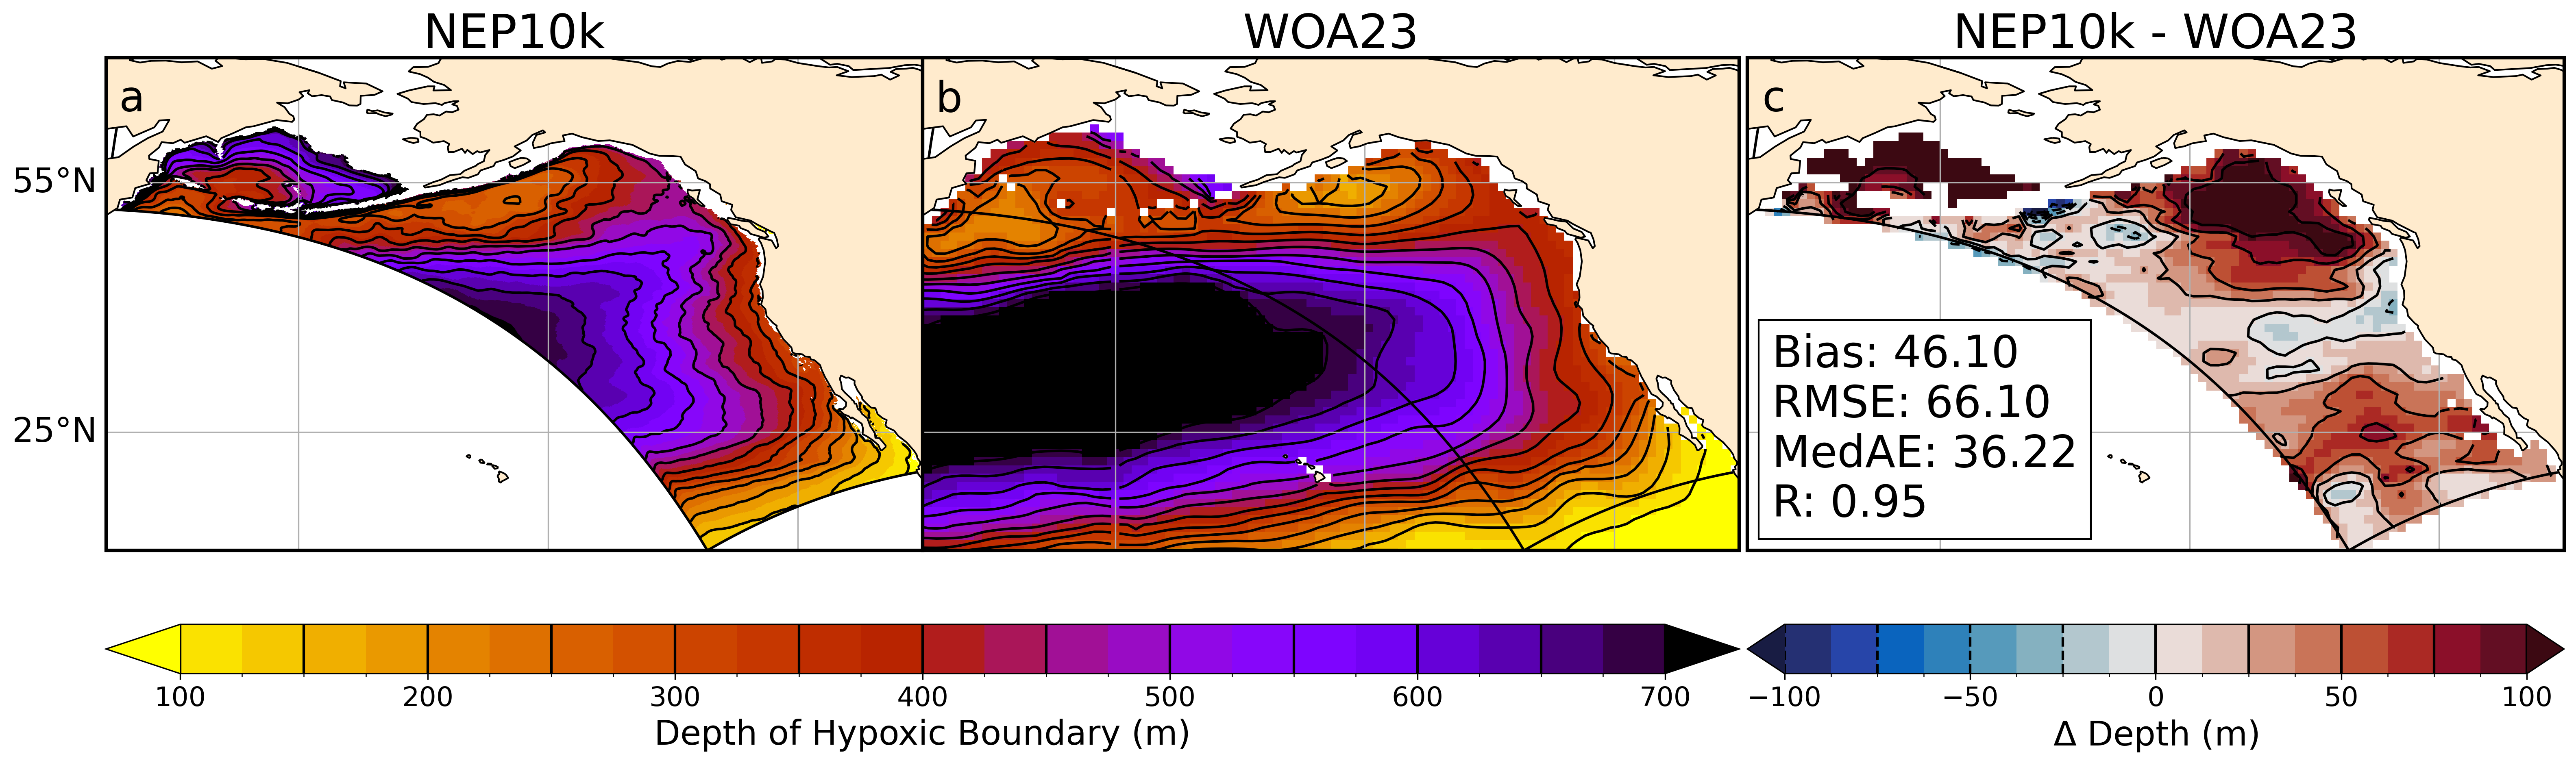

In [11]:
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1) 
heights = [10,2]
widths = [10,10,.1,10]
nutrient = 'Oxygen'
season='mean'
print_stats = True

do_conc_hypox = 61.7 # µmol/kg

fig = plt.figure(figsize=(26,18),dpi=300)
spec = fig.add_gridspec(ncols=4, nrows=2,wspace=0,hspace=0.,height_ratios=heights, width_ratios=widths)  
nrow = 0
nlab = 0
ncol = 0    
ds_NEP = get_model_ds('NEP')
ds_comp = get_model_ds('WOA')  

lat,lon,clat,clon,chuk_mask = get_coords('WOA',ds_comp)
sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,lsm,clon,clat)

const_offset = np.nanmax(lsm) + 10
sourcefield.data[...] = lsm + const_offset
destfield = regrid(sourcefield, destfield)
tmp_val = copy.deepcopy(destfield.data)
tmp_val[tmp_val==0] = np.nan
lsm_out = tmp_val - const_offset
lsm_out[lsm_out>.5]=1
lsm_out[lsm_out<.5]=0

# Get area for weighted statistics 
const_offset = np.nanmax(nep_area) + 10
sourcefield.data[...] = nep_area + const_offset
destfield = regrid(sourcefield, destfield)
tmp_val = copy.deepcopy(destfield.data)
tmp_val[tmp_val==0] = np.nan
area_out = tmp_val - const_offset

comp_val = ox_dict[nutrient]['WOA']['k']*ds_comp[ox_dict[nutrient]['WOA']['var_nm']].values.squeeze()
NEP_val = ox_dict[nutrient]['NEP']['k']*ds_NEP[ox_dict[nutrient]['NEP']['var_nm']].values.squeeze()

# calculate depth of hypoxic boundary
NEP_depth_interp = calc_hypox_bound(ds_NEP,NEP_val)
WOA_depth_interp = calc_hypox_bound(ds_comp,comp_val)

nj,ni = WOA_depth_interp.shape
WOA_depth_interp[lsm_out==0]=np.nan
WOA_depth_interp[chuk_mask]=np.nan

const_offset = np.nanmax(NEP_depth_interp) + 10

if np.ndim(NEP_depth_interp)>2:
    nt1 = len(NEP_depth_interp)
    NEP_val_out = np.zeros((nt1,nj,ni)) 
    
    for nt in range(nt1):
        sourcefield.data[...] = NEP_depth_interp[nt,:].squeeze() + const_offset
        destfield = regrid(sourcefield, destfield)
        tmp_val = copy.deepcopy(destfield.data)
        tmp_val[tmp_val==0] = np.nan
        NEP_val_out[nt,:] = tmp_val - const_offset
    NEP_val_out = np.mean(NEP_val_out,axis=0)
    
else:
    sourcefield.data[...] = NEP_depth_interp.squeeze() + const_offset
    destfield = regrid(sourcefield, destfield)
    tmp_val = copy.deepcopy(destfield.data)
    tmp_val[tmp_val==0] = np.nan
    NEP_val_out = tmp_val - const_offset
    
NEP_val_out[lsm_out==0]=np.nan
NEP_val_out[chuk_mask]=np.nan

nan_idx = ~np.isnan(NEP_val_out)*~np.isnan(WOA_depth_interp)
            
# Add subplot map to figure
plot_map(nep_clon,nep_clat,nep_lon,nep_lat,np.mean(NEP_depth_interp,axis=0), abs_min, abs_max,
             cmap1,norm1, 50)
            
ncol+=1
nlab+=1
            
plot_map(clon,clat,lon,lat,WOA_depth_interp,abs_min, abs_max,
             cmap1,norm1,50)
ncol+=2
nlab+=1

# CALCULATE STATISTICS
mean_bias, rmse, medae, corr = calc_stats(NEP_val_out,WOA_depth_interp,area_out)

plot_map(clon,clat,lon,lat,NEP_val_out-WOA_depth_interp,-dif_range,dif_range,cmap2,norm2,25)

nlab+=1
plt.savefig('Figure13_hypoxic_boundary_layer')
